# PHYS3009 Project: Modelling the Emission

Name:

Student No.:

total marks: 25

## Purpose of this Project

In this project you will learn how the energy spectrum from an observation can be used to study the astrophysical mechanisms at work in the source. This project will make use of the non-thermal radiation mechanisms learned in PHYS3008 and the data sets created in PHYS3009.

Two models will be studied: A hadronic model where all the emission comes from pion decay originating in the inellastic collisions of relativistic protons with ambient material. And a leptonic model where collisions of relativistic electrons with the Cosmic Microwave Background boost the low-energy photons to gamma-ray energies.

The parameters to be measured are the total energy and the cut-off of the particle spectrum (electrons or protons), and the magnetic field in the leptonic model. For the hadronic model it is not possible to directly measure the ambient particle density, but different options will be discussed.

You will need the data file you have created in the TeV Astronomy project. Further on, you need two data files, ```RXJ1713_Suzaku-XIS.dat``` and ```RXJ_4flg.ecsv```. You can download these files from Sakai. Place these files in the working directory of this notebook. If you are working on mybinder you will need to upload your own data file: Go to the jupyter home page (not this notebook, it is in a different tab or window of your browser) and click on Upload in the top-right corner. The two other files are already available on mybinder.

## Load and test the modules

As usual we will start with importing the necessary modules and we check the versions of ```naima``` and ```gammapy```.

In [ ]:
import naima

naima.__version__

In [ ]:
import gammapy

gammapy.__version__

In [ ]:
import numpy as np

np.__version__

In [ ]:
from astropy.table import Table

from astropy import units as u

import matplotlib.pyplot as plt

In [ ]:
from gammapy.estimators.flux_point import FluxPoints

from gammapy.datasets import FluxPointsDataset

from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    NaimaSpectralModel,
)

from gammapy.modeling import Fit

## Additional Parameters and Settings

We have measured the gamma-ray and radio flux on Earth and now we want to model the emission in the source. We will need the distance to the source. The distance cannot be measured directly from gamma rays or radio, and sometimes the distance is not known. Good for us that the distance to RX J1713.7-3946 is known.

In [ ]:
distance = 1*u.kpc

Let's define some parameters which will be used for plotting later. This includes the energy range of our models.

In [ ]:
plot_kwargs = {
    'energy_range': (1*u.eV,100*u.TeV),
    'energy_power': 2
}

## Loading the Data

### Reading the H.E.S.S. points

We have produced the data points with gammapy, so it should be easy to load them again.

In [ ]:
hesspoints = FluxPoints.read('J1713.dat', format='ipac')

In [ ]:
hesspoints.table

We see that everything is there what we have produced last time. But there is one problem.

In [ ]:
hesspoints.table['is_ul'].dtype

This column contains True and False, but as string unfortunately. Let's convert it to bool.

In [ ]:
hesspoints.table['is_ul'] = hesspoints.table['is_ul'] == 'True'

In [ ]:
hesspoints.plot()

The upper limits cannot be used in a fit and may lead to errors later on. Let's keep only the points that are not upper limits.

In [ ]:
hesspoints.table = hesspoints.table[hesspoints.table['is_ul'] == False]

Finally, we keep only the columns we need. This will make it easier to combine these points with the Fermi/LAT points.

In [ ]:
hesspoints.table = hesspoints.table['e_ref',
                                 'e_min',
                                 'e_max',
                                 'dnde',
                                 'dnde_ul',
                                 'dnde_err',
                                 'dnde_errp',
                                 'dnde_errn',
                                 'is_ul']

In [ ]:
hesspoints.table

In [ ]:
hesspoints.plot()

Now we create a data set which combines the flux points and a model we want to fit. We should use the same model as in the project before.

In [ ]:
hesspoints_ds = FluxPointsDataset(SkyModel(spectral_model=ExpCutoffPowerLawSpectralModel()), hesspoints)

Next we fit the model to the flux points.

In [ ]:
fit = Fit([hesspoints_ds])

result = fit.run()
print(result)
print(result.parameters.to_table())

These numbers are a bit different then what we have found in the direct fit to the data. This is due to the extra step of generating flux points and refitting these points. But within errors this agrees very well.

Make sure that your fit converged and make a plot of your result.    **[3 marks]**

In [ ]:
hesspoints_ds.peek()

Epected output:
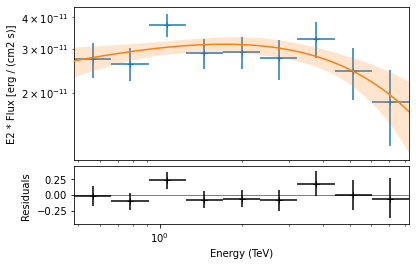

### Reading the Fermi/LAT Data Points

Let's do the same with the Fermi/LAT data points. If you work on your own computer then you need to download this file from Sakai. If you work on mybinder then the file is already in your working directory, nothing to do in this case.

Let's load the file.    **[1 mark]**

In [ ]:
fermipoints = FluxPoints.read('RXJ_4flg.ecsv')

In [ ]:
fermipoints.table

In [ ]:
fermipoints.sed_type

The Fermi/LAT points have a different format. What is picked up here is the flux in each bin. But we need the differential flux ```dnde```. Good for us that gammapy can do the conversion.

In [ ]:
fermipoints = fermipoints.to_sed_type('dnde')

In [ ]:
fermipoints.table

Columns for ```dnde``` have been added at the end. Let's keep only the columns we will need, this will help later.

In [ ]:
fermipoints.table = fermipoints.table['e_min',
                                     'e_max',
                                     'is_ul',
                                     'e_ref',
                                     'dnde',
                                     'dnde_errn',
                                     'dnde_errp',
                                     'dnde_ul']

In [ ]:
fermipoints.table

We also need symmetric errors for the fit. Let's take the average of the positive and negative error.

In [ ]:
fermipoints.table['dnde_err'] = (fermipoints.table['dnde_errn'] + fermipoints.table['dnde_errp'] )/2  

In [ ]:
fermipoints.plot()

Again, we will delete all the upper limits.

In [ ]:
fermipoints.table = fermipoints.table[fermipoints.table['is_ul']==False]

The Fermi/LAT points are in MeV, while the H.E.S.S. points are in TeV. gammapy should be able to hand it automatically, but I am afraid there is a bug. Let's convert it to TeV manually. First we write a function to do this. 

In [ ]:
# Convert all to TeV. Do we need this? FluxPointsDataSet seems to have a problem with other than TeV as unit.

def convert_to_TeV(table) :
    for c in ['e_min', 'e_max', 'e_ref'] :
        try:
            table[c] = table[c].to(u.TeV)
        except:
            pass

    for c in ['dnde', 'dnde_errn', 'dnde_errp', 'dnde_ul', 'dnde_err'] :
        try:
            table[c] = table[c].to(1/(u.TeV * u.cm**2 * u.s))
        except:
            pass

And then we call this function for the data points.

In [ ]:
convert_to_TeV(fermipoints.table)

In [ ]:
fermipoints.plot()

Let's create a data set. This time we will use a power law as model.

In [ ]:
fermipoints_ds = FluxPointsDataset(SkyModel(spectral_model=PowerLawSpectralModel()),fermipoints)

In [ ]:
fit = Fit([fermipoints_ds])

result = fit.run()
print(result)
print(result.parameters.to_table())

In [ ]:
fermipoints_ds.peek()

### Reading X-Ray Data Points

In order to fix the synchrotron emission we will measurements in radio or X-rays. Here we will use the results of a published study of RX J1713 by Tanaka et al. (2008) [http://adsabs.harvard.edu/abs/2008ApJ...685..988T]. A data file with these results came with an older version of ```naima```. If you work on your own computer then you need to download this file from Sakai. If you work on mybinder then the file is already in your working directory, nothing to do in this case. We cannot read this file directly into FluxPoints. But we can read it as a table, make the necessary changes and use it then as FluxPoints.

Let's load the file.    **[1 mark]**

In [ ]:
xraytable = Table.read('RXJ1713_Suzaku-XIS.dat', format = 'ipac')

In [ ]:
xraytable

We need to change the column names. The ```energy``` column should be called ```e_ref``` as in the other files. And the ```flux``` column here actually contains values for ```e2dnde```.

In [ ]:
xraytable['energy'].name = 'e_ref'
xraytable['flux'].name = 'e2dnde'
xraytable['flux_error'].name = 'e2dnde_err'

As the points are ```e2dnde``` we need to put this information into the table.

In [ ]:
xraytable.meta['SED_TYPE'] = 'e2dnde'

In [ ]:
xraytable

The energy unit here is eV. The spectrum ranges from 500 eV to 11 keV. Let's convert this to TeV as with the Fermi/LAT points.

In [ ]:
convert_to_TeV(xraytable)

In [ ]:
xraytable

Now we are ready to create the FluxPoints.

In [ ]:
xraypoints = FluxPoints(xraytable)

In [ ]:
xraypoints.plot()

The FluxPoints have to be converted to ```dnde```.

In [ ]:
xraypoints = xraypoints.to_sed_type('dnde')

In [ ]:
xraypoints.table

Finally we create the data set. Here we can use a power law with exponential cut-off.

In [ ]:
x_ds = FluxPointsDataset(SkyModel(spectral_model=
                                  ExpCutoffPowerLawSpectralModel(amplitute = 7e-13/(u.TeV * u.s * u.cm**2),
                                                                 lambda_ = 0.2/u.keV)),
                         xraypoints)

Note that start parameters have to be set. Otherwise the fit will not converge. The problem is that the reference energy of 1 TeV is far outside the energy range of the data points.

In [ ]:
fit = Fit([x_ds])

result = fit.run()
print(result)
print(result.parameters.to_table())

In [ ]:
x_ds.peek()

****
*Note.* You see that depending on the origin of your data some preparation is needed. It is important to understand what your files contain and what you want to do with it.
****

# Combine the Gamma-Ray Flux Points

The MeV to GeV and TeV flux points where obtained with different instruments and different techniques but usually the emission comes from the same processes. So we can combine these points and analyse together.

Within ```gammapy``` we can just stack the flux points.

In [ ]:
gammapoints = FluxPoints.stack([hesspoints, fermipoints])

In [ ]:
gammapoints.plot(energy_power=2)

In [ ]:
gammapoints.table

We can also create a DataSet and fit a model function. We established already that the H.E.S.S. data points show a significant exponential cut-off. Otherwise we would try a simple power law and a cut-off power law and compare with the likelihood ratio test. In some cases Fermi/LAT and H.E.S.S. data on their own do not show a cut-off, but when combining them together a cut-off can be found.

In [ ]:
gamma_ds = FluxPointsDataset(SkyModel(spectral_model=ExpCutoffPowerLawSpectralModel()), gammapoints)

In [ ]:
fit = Fit([gamma_ds])

result = fit.run()
print(result)
print(result.parameters.to_table())

Make sure that the fit terminated successfully. You should see a value for ```total stat```, and for each parameter a value and an error. If this is not the case you should change the parameters of the proton model, recreate the FluxPointDataSet and fit again.

When this is done you can make a plot of the result. **[3 marks]**

In [ ]:
# your code here

Expected output:
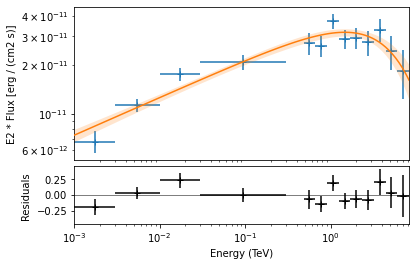

You see that the fit of the spectral index is dominated by Fermi/LAT and the cut-off lies well in the H.E.S.S. energy range. The best-fit parameters we find here are in good agreement with what we found above from the individual fits.

## Fitting Astrophysical Models

So far, we have fitted power laws to our data. We just described the shape of the spectrum. Now we want to fit astrophysical models and measure astrophysical parameters.

We will take a population of protons or electrons and model the gamma-ray emission from these particles. The energy spectrum of these particles should follow a power law with exponential cut-off. Let's define the two populations. 

We will use the ```ExponentialCutoffPowerLaw``` functions from ```naima``` as we have done in PHYS3008. This is a with a super-exponential cut-off,
$$
\frac{dN}{dE} = A \times \left( \frac{E}{E_0} \right) ^{-\alpha} \times \exp \left( - \left(\frac{E}{E_\mathsf{cutoff}}\right)^\beta \right),
$$
where we will set $\beta = 1$ to obtain a normal exponential cut-off. We will set all parameters to some meaningful values.

In [ ]:
# proton distribution
protons = naima.models.ExponentialCutoffPowerLaw(amplitude = 1e45 / u.eV,
                                                 e_0 = 1 * u.TeV,
                                                 alpha = 2.0, 
                                                 e_cutoff = 10 * u.TeV,
                                                 beta = 1)

In [ ]:
# electron distribution
electrons = naima.models.ExponentialCutoffPowerLaw(amplitude = 1e45 / u.eV,
                                                   e_0 = 1 * u.TeV,
                                                   alpha = 2.0,
                                                   e_cutoff = 1 * u.TeV,
                                                   beta = 1)

### Hadronic Model

In a hadronic model the protons collide with ambient material. The neutral pions produced in these collisions decay into gamma rays. The only parameter in this process is the target particle density $n$. We will set $n$ to one particle per cubic-centimetre. We will see later how this scales with our result.

In [ ]:
n = 1./ u.cm**3

Next we create a model for pion decays from ```naima```.

In [ ]:
hadronic = naima.models.PionDecay(protons, n)

We expect that out of the supernova's explosion energy of about $10^{51}$ erg around 10% go into relativistic protons. Let's set the total energy of protons to $10^{50}$ erg. This will change the amplitude of our proton distribution but not any other parameter.

In [ ]:
hadronic.set_Wp(1e50*u.erg)

This is a ```naima``` model, we want to include this in ```gammapy```. There is a ```NaimaSpectralModel``` for this. We will also add the distance to the source.

In [ ]:
hadronic_model = NaimaSpectralModel(hadronic, distance=distance)

In [ ]:
hadronic_model.parameters.to_table()

All parameters are free for the fit. We cannot fit the reference energy ```e_0``` we must freeze it.

In [ ]:
hadronic_model.parameters['e_0'].frozen = True

We could fit the ```beta``` parameter as well. But then we will need to check if it is significantly different from 1. Let's keep this parameter at 1 and freeze it.

In [ ]:
hadronic_model.parameters['beta'].frozen = True

In [ ]:
hadronic_model.parameters.to_table()

Now we create a new FluxPointsDataSet with the new model and perform the fit.

In [ ]:
hadronic_ds = FluxPointsDataset(SkyModel(spectral_model=hadronic_model), gammapoints)

In [ ]:
fit = Fit([hadronic_ds])
result = fit.run()
print(result)
print(result.parameters.to_table())

Make sure that your fit converged and make a plot of your result.    **[3 marks]**

In [ ]:
# your code here

Expected output:
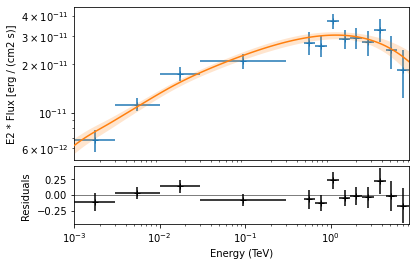

One interesting result is the cut-off of the proton spectrum:

In [ ]:
print('Cut-off energy: E_cut = ({:3.0f} +/- {:2.0f}) {}'.format(
                                                hadronic_model.parameters['e_cutoff'].value,
                                                hadronic_model.parameters['e_cutoff'].error,
                                                hadronic_model.parameters['e_cutoff'].unit))

If the hadronic model is true than the supernova remnant can accelerate protons to more than 100 TeV. Compare this with energies achieved at particle accelerators at CERN. One goal of gamma-ray astronomy is to find sources that can accelerate up to 1000 TeV. We are not there yet...

Another scientific question is about the total energy in protons. We can get this number from the hadronic model:

In [ ]:
W_p = hadronic.Wp

In [ ]:
W_p

This corresponds to about 8% of the supernova's explosion energy. Keep in mind that this is for a target density of $n = 1/\mathsf{cm}^3$. The total energy in protons scales inversely proportional with the density:
$$
W_\mathsf{tot} = W_p \times \left( \frac{n}{1\,\mathsf{cm}^{-3}} \right)^{-1}
$$
$W_p$ is the number from the above cell.

**Exercise:**    **[3 marks]**

1. What would be the total energy if the density would be $n = 10 / \mathsf{cm}^3$? No need to redo the fit.
1. What would be the required density for the emission if the total energy would be $W_\mathsf{tot} = 10^{50} \,\mathsf{erg}$?

In [ ]:
# This is a code cell. You can put your calculations here.

**Answer:**

This is a text cell. Put your answer here.

If you want to use the likelihood of the fit, here it is:

In [ ]:
L_hadronic = result.total_stat

### Inverse Compton Model

When relativistic electrons scatter off photon fields energy is transferred to the photon. This is Inverse Compton scattering and the energy of the photons is in the GeV to TeV energy range.

Here we will use only the Cosmic Microwave Background as seed photon fields.

In [ ]:
photon_fields = ['CMB']

We create an Inverse Compton model from ```naima```. Remember that we have to set the minimum energy here to the rest energy of the electron.

In [ ]:
IC = naima.models.InverseCompton(electrons, photon_fields, Eemin = 511*u.keV)

As above, we will set the total energy and we create a ```NaimaSpectralModel``` with the correct distance.

In [ ]:
IC.set_We(1e49*u.erg)

IC_model = NaimaSpectralModel(IC, distance=distance)

In [ ]:
IC_model.parameters.to_table()

We must freeze the reference energy and we want to freeze the beta parameter.

In [ ]:
IC_model.parameters['e_0'].frozen = True

In [ ]:
IC_model.parameters['beta'].frozen = True

In [ ]:
IC_model.parameters.to_table()

We create a FluxPointDataSet.

In [ ]:
IC_ds = FluxPointsDataset(SkyModel(spectral_model=IC_model), gammapoints)

And we fit the model.

In [ ]:
fit = Fit([IC_ds])
result = fit.run()
print(result)
print(result.parameters.to_table())

Make sure that the fit terminated successfully and make a plot of the result. **[3 marks]**

In [ ]:
# your code here

Expected output:
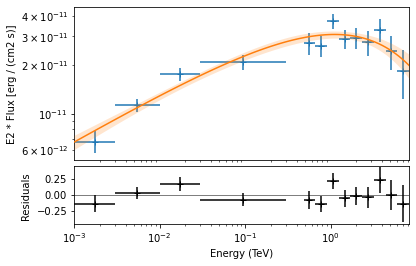

We can find the total energy in electrons and the cut-off energy of the electron spectrum:

In [ ]:
print('W_e = {}'.format(IC.We))
print('Cut-off energy: E_cut = ({:3.3f} +/- {:2.3f}) {}'.format(
                                                IC_model.parameters['e_cutoff'].value,
                                                IC_model.parameters['e_cutoff'].error,
                                                IC_model.parameters['e_cutoff'].unit))

Note that both values are lower than the corresponding values of the proton spectrum. The total energy is lower because the mass of an electron is much smaller than the mass of a proton. The cut-off energy is lower because electrons loose their energy much quicker than protons, mainly due to synchrotron radiation.

If you want to use the likelihood of the fit, here it is:

In [ ]:
L_IC = result.total_stat

#### Comparing Hadronic and Leptonic Model

Let's make a plot of the two models.

In [ ]:
gammapoints.plot(energy_power=2)

IC_model.plot(energy_range=(1e-4*u.TeV, 100*u.TeV), energy_power=2, label = 'inverse Compton')
hadronic_model.plot(energy_range=(1e-4*u.TeV, 100*u.TeV), energy_power=2, label = 'pion decay')

plt.legend()

Both models are independent and describe the data points well. Only one model can be correct. Can you make a claim if one model is significantly better? Explain your answer.

If you apply Wilk's theorem, which one is your null hypothesis? In this case you need to show that the null hypothesis is a special case of the alternative model!

**[2 marks]**

**Answer:**

This is a text cell. Put your answer here.

### Adding Synchtrotron Emission

From the inverse Compton model above we have deduced an electron spectrum. In a magnetic field these electrons will also produce synchrotron radiation. Synchrotron radiation shows in radio up to X-ray energies. We have loaded the data points above.

Let's take a look at the parameters of the inverse-Compton model:

In [ ]:
IC_model.parameters.to_table()

Let's build a model for synchrotron radiation from these electrons. We will start with a magnetic field of $B = 1 \mu\mathsf{G}$.

In [ ]:
B = 1*u.microGauss

We use the synchrotron model from ```naima``` with a minimum energy corresponding to the rest energy of the electron. We build a NaimaSpectralModel with the correct distance.

In [ ]:
sync = naima.models.Synchrotron(electrons, B = B, Eemin = 511*u.keV)

sync_model = NaimaSpectralModel(sync, distance=distance)

The synchrotron radiation comes from the same electrons as the inverse Compton emission. So the parameters should be the same.

In [ ]:
sync_model.amplitude = IC_model.amplitude
sync_model.e_0 = IC_model.e_0
sync_model.e_cutoff = IC_model.e_cutoff
sync_model.alpha = IC_model.alpha
sync_model.beta = IC_model.beta

In [ ]:
sync_model.parameters.to_table()

We want to keep the electrons as we have found them from the fit to gamma-ray data. So we have to freeze all parameters except the magnetic field.

In [ ]:
for c in ['amplitude', 'e_0', 'alpha', 'e_cutoff', 'beta'] :
    sync_model.parameters[c].frozen = True

In [ ]:
sync_model.parameters.to_table()

Now we can plot our models together with all data points.

In [ ]:
gammapoints.plot(energy_power=2)
xraypoints.plot(energy_power=2)

IC_model.plot(**plot_kwargs, label = 'IC')
sync_model.plot(**plot_kwargs, label = 'synchrotron')

plt.legend()
plt.ylim(1e-13, 1e-9)

The synchrotron model is well below the X-ray data points. We will need to increase the magnetic field. We just fit to the data points, the magnetic field is the only free parameter in the model.

Let's create the FluxPointDataSet and do the fit.

In [ ]:
sync_ds = FluxPointsDataset(SkyModel(spectral_model=sync_model), xraypoints)

In [ ]:
fit = Fit([sync_ds])
result = fit.run()
print(result)
print(result.parameters.to_table())

Make sure that the fit terminated successfully and make a plot of the result. **[3 marks]**

In [ ]:
#your code here

Expected output:
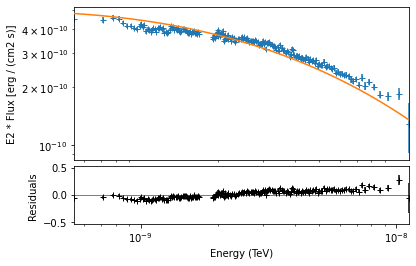

You see that the shape of the spectrum does not describe very well the data points. The reason is that we fixed the shape using gamma-ray data. Here we only adjusted the magnetic field such that the level of emission is right.

What is the magnetic field? Report your answer with error and unit. **[1 mark]**

In [ ]:
# your answer here

Let's plot all together.

In [ ]:
gammapoints.plot(energy_power=2)
xraypoints.plot(energy_power=2)

IC_model.plot(**plot_kwargs, label = 'IC')
sync_model.plot(**plot_kwargs, label = 'synchrotron')

plt.legend()
plt.ylim(1e-13, 1e-9)

### Further Ideas

We can try to address the problem that our model does not describe well the shape of the X-ray spectrum. The X-ray spectrum is mainly in the cut-off range. We can free the parameters of the cut-off energy and ```beta```. The spectral index ```alpha``` is constraint by the gamma-ray emission, so we keep it fixed. We also keep the amplitude fixed, otherwise the model will be too far away from the gamma-ray points.

In [ ]:
sync_model.parameters['e_cutoff'].frozen = False
sync_model.parameters['beta'].frozen = False

In [ ]:
sync_model.parameters.to_table()

In [ ]:
result = fit.run()
print(result)
print(result.parameters.to_table())

In [ ]:
sync_ds.peek()

This worked well. Let's have a look what this does to the inverse Compton emission.

In [ ]:
IC_ds.peek()

Now our model overestimates the emission in the cut-off region.

The best thing to do would be to fit both models and all data points simultanously. The next cell would be the way to do it. Unfortunately, there is a bug in gammapy v. 0.17, so this does not work. It will work in v. 0.18, which should come out Oct 30th.

In [ ]:
#fit = Fit([sync_ds, IC_ds])
#result = fit.run()
#print(result)
#print(result.parameters.to_table())

Here are two plots after the above simultanous fit, with beta as free parameter. The cut-off region of the gamma-ray emission is still slightly overestimated.
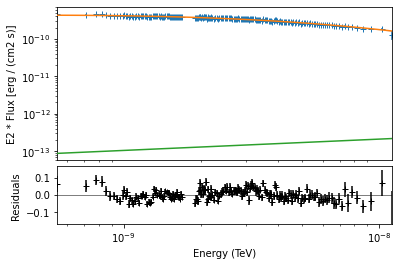
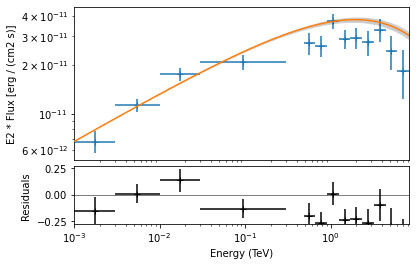

## Sanity Check

Before you submit your work you should make a few checks that everything works fine.

1. ~~Save your notebook as a PDF (File->Download As->PDF). This document will help you debugging in the next step.~~
1. PDF export does not work. You can do File->Print Preview and then print to a file.
1. Restart the kernel and rerun the entire notebook (Kernel->Restart & Run All). This will delete all variables (but not your code) and rerun the notebook in one go. If this does not go through the end (i.e. you do not see the output of the next cell) then you have to fix it. You will see at which cell the run stopped. A common mistake is using a variable that is defined only at a later stage.
1. You think you fixed everything? Redo step 2 (Kernel->Restart & Run All)

In [ ]:
print('a\bYa\boa\bua\b a\baa\bra\bea\b a\bra\bea\baa\bda\bya\b a\bta\boa\b a\bsa\bua\bba\bma\bia\bta\b.a\b')

Do you see the output of the last cell without explicitly running it? Then the notebook goes through with one kernel restart. You can proceed to submission.
You do not see the output? Go back to step 2 above.

The jupyter notebook goes through all cells with one Kernel Restart & Run all.    **[1 mark]**

## Submission

You have to download and submit at least 3 files, the jupyter notebook and the two data files.
- Jupyter notebook. File->Download As->Notebook (.ipynb). Save this file on your disk.
- Spectral data points. Go to the Home Page of your jupyter notebooks. It is in a different tab or window of your browser. Find your two data files and save it to your disk. No need to download the X-ray file.
- ~~You can also submit a PDF file. File->Download As->PDF. Save this file on your disk. If this does not work then leave it out.~~
- PDF export does not work. You can do File->Print Preview and then print to a file.


Please submit all files on Sakai.        **[1 mark]**

Congratulations. You have succesfully completed your TeV Astronomy project.